# 슈퍼마켓 매출 예측
- 가구 세일 데이터 사용


In [58]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels as sm

%config InlineBackend.figure_format = 'retina'

## 데이터 읽기

In [40]:
df = pd.read_excel("https://raw.githubusercontent.com/StillWork/data/master/superstore.xls")

In [41]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [43]:
df[:3].T

,0,1,2
Row ID,1,2,3
Order ID,CA-2016-152156,CA-2016-152156,CA-2016-138688
Order Date,2016-11-08 00:00:00,2016-11-08 00:00:00,2016-06-12 00:00:00
Ship Date,2016-11-11 00:00:00,2016-11-11 00:00:00,2016-06-16 00:00:00
Ship Mode,Second Class,Second Class,Second Class
Customer ID,CG-12520,CG-12520,DV-13045
Customer Name,Claire Gute,Claire Gute,Darrin Van Huff
Segment,Consumer,Consumer,Corporate
Country,United States,United States,United States
City,Henderson,Henderson,Los Angeles


In [44]:
furniture = df.loc[df['Category'] == 'Furniture']
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [45]:
furniture = furniture[["Order Date", "Sales"]]
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [46]:
furniture = furniture.set_index('Order Date')
furniture[:3]

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940


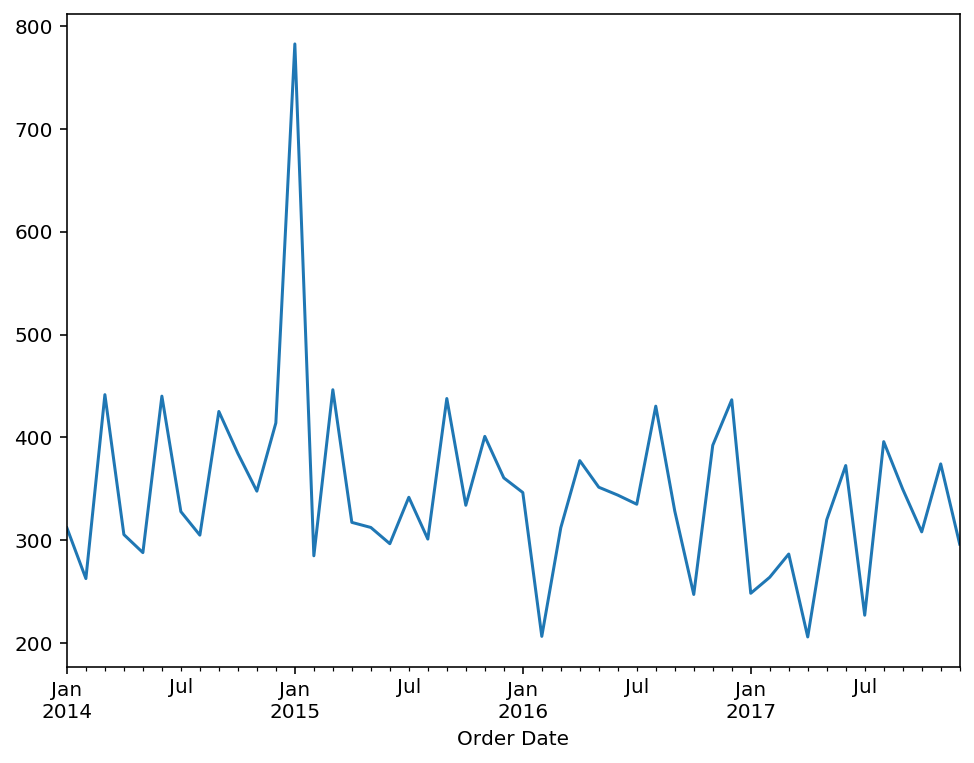

In [47]:
# 월별 통계로 전환
y = furniture['Sales'].resample('MS').mean()
y.plot(figsize=(8, 6))
plt.show()

# ARIMA 예측
## 데이터 분해
- seasonality, trend and noise: ARIMA(p, d, q): 

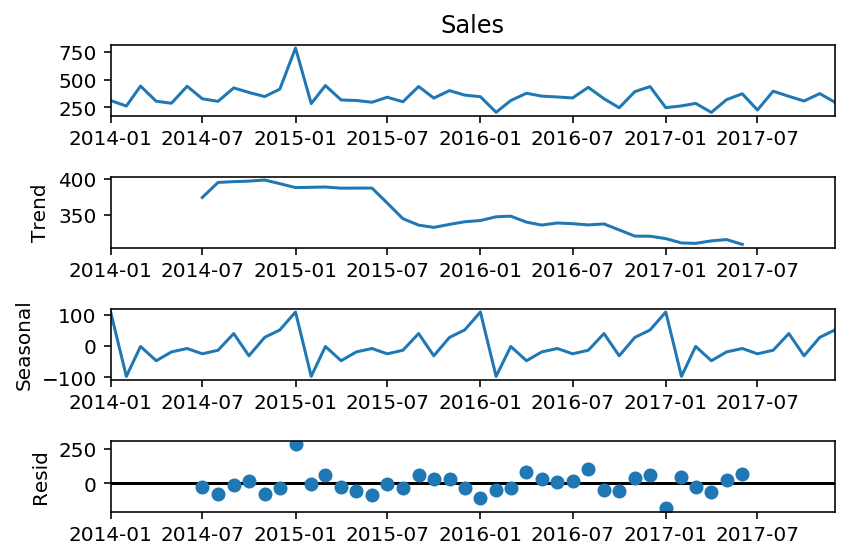

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels as sm
decomposition = seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [54]:
p = range(0, 4) # n_steps_in (30)
d = range(0, 2) # 0, 1
q = range(0, 2) # 0,1,2
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1),
 (2, 0, 0),
 (2, 0, 1),
 (2, 1, 0),
 (2, 1, 1),
 (3, 0, 0),
 (3, 0, 1),
 (3, 1, 0),
 (3, 1, 1)]

In [55]:
# 주기가 12임을 가정
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


### 최적 파라미터 선택

In [61]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.sarimax.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)    
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:688.3112416991725
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1324.3661507188137
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:426.20464898591723
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:272.091984762829


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:452.8238602501691
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:421.17561100533294
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:295.446456472235
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:274.0919845632784
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:289.2973071528371
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:290.01744065287687
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:142.03331632709168


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:144.1343717080058
ARIMA(0, 0, 0)x(3, 0, 0, 12)12 - AIC:138.09452240437685
ARIMA(0, 0, 0)x(3, 0, 1, 12)12 - AIC:140.0945224528673
ARIMA(0, 0, 0)x(3, 1, 0, 12)12 - AIC:8.0
ARIMA(0, 0, 0)x(3, 1, 1, 12)12 - AIC:10.0
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:641.1240680666111


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2770.094868051153
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:416.5496453364603
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:262.52305170477035


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:455.1399666311057


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:411.5786216781468
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:297.44640662502263
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:264.5230013128143
ARIMA(0, 0, 1)x(2, 0, 0, 12)12 - AIC:291.0407172101883


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(2, 0, 1, 12)12 - AIC:293.54771462685386
ARIMA(0, 0, 1)x(2, 1, 0, 12)12 - AIC:141.34587927303184
ARIMA(0, 0, 1)x(2, 1, 1, 12)12 - AIC:143.3368336471338
ARIMA(0, 0, 1)x(3, 0, 0, 12)12 - AIC:138.32286380333647


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(3, 0, 1, 12)12 - AIC:140.25658839302272
ARIMA(0, 0, 1)x(3, 1, 0, 12)12 - AIC:10.0
ARIMA(0, 0, 1)x(3, 1, 1, 12)12 - AIC:12.0
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:580.6389269639644


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1296.1966120951458
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:433.35521367347195
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:274.1069295746927
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:437.46040107889746


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1300.2660573079893
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:294.1158452476943
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:276.1053314166441
ARIMA(0, 1, 0)x(2, 0, 0, 12)12 - AIC:274.8167921774723
ARIMA(0, 1, 0)x(2, 0, 1, 12)12 - AIC:276.59610133664927
ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:134.94603883090548
ARIMA(0, 1, 0)x(2, 1, 1, 12)12 - AIC:136.90816006331
ARIMA(0, 1, 0)x(3, 0, 0, 12)12 - AIC:135.56393220669958
ARIMA(0, 1, 0)x(3, 0, 1, 12)12 - AIC:137.56393221175088
ARIMA(0, 1, 0)x(3, 1, 0, 12)12 - AIC:8.0
ARIMA(0, 1, 0)x(3, 1, 1, 12)12 - AIC:10.0
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:538.8964721447171
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:3084.5433502012793
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:412.8726989905177
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:251.2470775508359
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:419.1839792724932


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:273.4032454636578
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:253.21964764619779
ARIMA(0, 1, 1)x(2, 0, 0, 12)12 - AIC:266.993309937958
ARIMA(0, 1, 1)x(2, 0, 1, 12)12 - AIC:268.52353418168974
ARIMA(0, 1, 1)x(2, 1, 0, 12)12 - AIC:131.5271261681475
ARIMA(0, 1, 1)x(2, 1, 1, 12)12 - AIC:133.0941470876431
ARIMA(0, 1, 1)x(3, 0, 0, 12)12 - AIC:131.12978362792217
ARIMA(0, 1, 1)x(3, 0, 1, 12)12 - AIC:132.48827033818833
ARIMA(0, 1, 1)x(3, 1, 0, 12)12 - AIC:10.0
ARIMA(0, 1, 1)x(3, 1, 1, 12)12 - AIC:12.0
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:592.7661498749849


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1252.8512814633632
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:427.7241159738327
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:273.582068437108
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:420.41145389920393
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:422.2922065194194
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:273.5840395565942
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:275.5784303961399
ARIMA(1, 0, 0)x(2, 0, 0, 12)12 - AIC:276.4868589411333
ARIMA(1, 0, 0)x(2, 0, 1, 12)12 - AIC:278.2670031627694
ARIMA(1, 0, 0)x(2, 1, 0, 12)12 - AIC:132.94980701051816
ARIMA(1, 0, 0)x(2, 1, 1, 12)12 - AIC:134.1994635999048
ARIMA(1, 0, 0)x(3, 0, 0, 12)12 - AIC:128.5951509238767
ARIMA(1, 0, 0)x(3, 0, 1, 12)12 - AIC:130.59515093892412
ARIMA(1, 0, 0)x(3, 1, 0, 12)12 - AIC:10.0
ARIMA(1, 0, 0)x(3, 1, 1, 12)12 - AIC:12.0
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:553.2719417804337
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:3089.7987255063535
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:418.5261783089186
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 -

/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 1, 1, 12)12 - AIC:134.5951779557719
ARIMA(1, 0, 1)x(3, 0, 0, 12)12 - AIC:130.542905331645


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(3, 0, 1, 12)12 - AIC:132.83217721602796
ARIMA(1, 0, 1)x(3, 1, 0, 12)12 - AIC:12.0
ARIMA(1, 0, 1)x(3, 1, 1, 12)12 - AIC:14.0
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:566.5211872508684


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1363.7299705795044
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:430.3305770817933
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:273.43213783259756
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:397.36689816515593


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1068.8170935523485
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:273.4415398792928
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:275.4127857749971
ARIMA(1, 1, 0)x(2, 0, 0, 12)12 - AIC:263.52006510828835
ARIMA(1, 1, 0)x(2, 0, 1, 12)12 - AIC:263.683498098434
ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:123.34020348138239


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 1, 1, 12)12 - AIC:125.48272144392296
ARIMA(1, 1, 0)x(3, 0, 0, 12)12 - AIC:123.84269503808703
ARIMA(1, 1, 0)x(3, 0, 1, 12)12 - AIC:125.84269503289639
ARIMA(1, 1, 0)x(3, 1, 0, 12)12 - AIC:10.0
ARIMA(1, 1, 0)x(3, 1, 1, 12)12 - AIC:12.0
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:540.6257368397364


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2511.949524294966
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:414.7726173043037
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:252.6613432747537
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:391.83032555547567
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2460.0839964598263


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:263.9371084381281
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:254.64207132026118
ARIMA(1, 1, 1)x(2, 0, 0, 12)12 - AIC:256.8329847036389
ARIMA(1, 1, 1)x(2, 0, 1, 12)12 - AIC:256.7280393053536
ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:120.66731497879864
ARIMA(1, 1, 1)x(2, 1, 1, 12)12 - AIC:121.37063754694583
ARIMA(1, 1, 1)x(3, 0, 0, 12)12 - AIC:122.3342624274664
ARIMA(1, 1, 1)x(3, 0, 1, 12)12 - AIC:124.33038937511125
ARIMA(1, 1, 1)x(3, 1, 0, 12)12 - AIC:12.0
ARIMA(1, 1, 1)x(3, 1, 1, 12)12 - AIC:14.0
ARIMA(2, 0, 0)x(0, 0, 0, 12)12 - AIC:568.1567806973037


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(0, 0, 1, 12)12 - AIC:1929.3936154477324
ARIMA(2, 0, 0)x(0, 1, 0, 12)12 - AIC:418.52730463250714
ARIMA(2, 0, 0)x(0, 1, 1, 12)12 - AIC:275.3244257201593
ARIMA(2, 0, 0)x(1, 0, 0, 12)12 - AIC:398.3967982072475
ARIMA(2, 0, 0)x(1, 0, 1, 12)12 - AIC:400.21873381725203
ARIMA(2, 0, 0)x(1, 1, 0, 12)12 - AIC:264.24189290179135
ARIMA(2, 0, 0)x(1, 1, 1, 12)12 - AIC:266.2415889158828
ARIMA(2, 0, 0)x(2, 0, 0, 12)12 - AIC:265.4946584831517
ARIMA(2, 0, 0)x(2, 0, 1, 12)12 - AIC:261.5820337244414
ARIMA(2, 0, 0)x(2, 1, 0, 12)12 - AIC:123.06827042878692
ARIMA(2, 0, 0)x(2, 1, 1, 12)12 - AIC:125.03478430914393


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(3, 0, 0, 12)12 - AIC:117.79442952141957


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(3, 0, 1, 12)12 - AIC:120.08902144821627
ARIMA(2, 0, 0)x(3, 1, 0, 12)12 - AIC:12.0
ARIMA(2, 0, 0)x(3, 1, 1, 12)12 - AIC:14.0
ARIMA(2, 0, 1)x(0, 0, 0, 12)12 - AIC:554.9819362784308
ARIMA(2, 0, 1)x(0, 0, 1, 12)12 - AIC:2685.8675221780763
ARIMA(2, 0, 1)x(0, 1, 0, 12)12 - AIC:420.528524595689
ARIMA(2, 0, 1)x(0, 1, 1, 12)12 - AIC:265.69486462811415
ARIMA(2, 0, 1)x(1, 0, 0, 12)12 - AIC:388.4472314717428


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 0, 1, 12)12 - AIC:390.1665246523168
ARIMA(2, 0, 1)x(1, 1, 0, 12)12 - AIC:264.23231893577156


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 1, 1, 12)12 - AIC:265.80334787268293


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 0, 12)12 - AIC:261.599533715475


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 1, 12)12 - AIC:262.9432286253877
ARIMA(2, 0, 1)x(2, 1, 0, 12)12 - AIC:120.77376069714578


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 1, 1, 12)12 - AIC:126.92721723663234


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(3, 0, 0, 12)12 - AIC:116.86517270574225


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(3, 0, 1, 12)12 - AIC:123.0649622535206
ARIMA(2, 0, 1)x(3, 1, 0, 12)12 - AIC:14.0
ARIMA(2, 0, 1)x(3, 1, 1, 12)12 - AIC:16.0
ARIMA(2, 1, 0)x(0, 0, 0, 12)12 - AIC:545.6702720107501
ARIMA(2, 1, 0)x(0, 0, 1, 12)12 - AIC:1451.1819766216652
ARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC:416.4283404910714
ARIMA(2, 1, 0)x(0, 1, 1, 12)12 - AIC:273.0800604119353
ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC:386.26020925770007


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(1, 0, 1, 12)12 - AIC:1303.1578689911137
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC:262.65549158854265
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:263.69155124814347
ARIMA(2, 1, 0)x(2, 0, 0, 12)12 - AIC:244.4416094360266
ARIMA(2, 1, 0)x(2, 0, 1, 12)12 - AIC:245.75447463961638
ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:104.00362352592532
ARIMA(2, 1, 0)x(2, 1, 1, 12)12 - AIC:105.65924506624793
ARIMA(2, 1, 0)x(3, 0, 0, 12)12 - AIC:104.22044109220097
ARIMA(2, 1, 0)x(3, 0, 1, 12)12 - AIC:106.22044117282772
ARIMA(2, 1, 0)x(3, 1, 0, 12)12 - AIC:12.0
ARIMA(2, 1, 0)x(3, 1, 1, 12)12 - AIC:14.0
ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:542.6223688912262
ARIMA(2, 1, 1)x(0, 0, 1, 12)12 - AIC:2512.9193145167824
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:416.4486558640099
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:252.93165844585147
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:376.2846159929624
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:2459.528483229533
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:253.07344070332363
ARIMA(2, 1, 1)x(1, 1, 1, 

/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:244.62265469437745
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:105.99935831687179


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:112.23850090307589
ARIMA(2, 1, 1)x(3, 0, 0, 12)12 - AIC:102.0444592937622


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(3, 0, 1, 12)12 - AIC:104.045061433533
ARIMA(2, 1, 1)x(3, 1, 0, 12)12 - AIC:14.0
ARIMA(2, 1, 1)x(3, 1, 1, 12)12 - AIC:16.0
ARIMA(3, 0, 0)x(0, 0, 0, 12)12 - AIC:547.4079133510922
ARIMA(3, 0, 0)x(0, 0, 1, 12)12 - AIC:1591.8911887801498
ARIMA(3, 0, 0)x(0, 1, 0, 12)12 - AIC:409.3601617133018
ARIMA(3, 0, 0)x(0, 1, 1, 12)12 - AIC:277.0060731221946
ARIMA(3, 0, 0)x(1, 0, 0, 12)12 - AIC:387.3596139179254
ARIMA(3, 0, 0)x(1, 0, 1, 12)12 - AIC:389.35256605983216
ARIMA(3, 0, 0)x(1, 1, 0, 12)12 - AIC:251.41662572231678
ARIMA(3, 0, 0)x(1, 1, 1, 12)12 - AIC:251.96271723509273
ARIMA(3, 0, 0)x(2, 0, 0, 12)12 - AIC:246.44160579683464
ARIMA(3, 0, 0)x(2, 0, 1, 12)12 - AIC:246.8629304887283
ARIMA(3, 0, 0)x(2, 1, 0, 12)12 - AIC:104.9581627603503
ARIMA(3, 0, 0)x(2, 1, 1, 12)12 - AIC:105.15997232705071
ARIMA(3, 0, 0)x(3, 0, 0, 12)12 - AIC:105.4774729283416
ARIMA(3, 0, 0)x(3, 0, 1, 12)12 - AIC:107.47747286896102
ARIMA(3, 0, 0)x(3, 1, 0, 12)12 - AIC:14.0
ARIMA(3, 0, 0)x(3, 1, 1, 12)12 - AIC:16.0


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 1)x(0, 0, 0, 12)12 - AIC:542.7887090057021


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 1)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(3, 0, 1)x(0, 1, 0, 12)12 - AIC:411.35997956034686
ARIMA(3, 0, 1)x(0, 1, 1, 12)12 - AIC:267.9198156715852


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 1)x(1, 0, 0, 12)12 - AIC:390.5948183392429


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 1)x(1, 0, 1, 12)12 - AIC:381.8043812422626
ARIMA(3, 0, 1)x(1, 1, 0, 12)12 - AIC:250.27018181744265


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 1)x(1, 1, 1, 12)12 - AIC:252.15452021212636
ARIMA(3, 0, 1)x(2, 0, 0, 12)12 - AIC:245.65845195809732


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 1)x(2, 0, 1, 12)12 - AIC:251.79785720648735
ARIMA(3, 0, 1)x(2, 1, 0, 12)12 - AIC:106.87083228026623
ARIMA(3, 0, 1)x(2, 1, 1, 12)12 - AIC:107.15993195574845


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 1)x(3, 0, 0, 12)12 - AIC:104.98028379303437


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 1)x(3, 0, 1, 12)12 - AIC:107.28028359834713
ARIMA(3, 0, 1)x(3, 1, 0, 12)12 - AIC:16.0
ARIMA(3, 0, 1)x(3, 1, 1, 12)12 - AIC:18.0
ARIMA(3, 1, 0)x(0, 0, 0, 12)12 - AIC:534.8422357427852


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(0, 0, 1, 12)12 - AIC:1347.6165854856863
ARIMA(3, 1, 0)x(0, 1, 0, 12)12 - AIC:404.9618169407695
ARIMA(3, 1, 0)x(0, 1, 1, 12)12 - AIC:274.3249198188623
ARIMA(3, 1, 0)x(1, 0, 0, 12)12 - AIC:371.41156398325995


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(1, 0, 1, 12)12 - AIC:1163.2353174204122
ARIMA(3, 1, 0)x(1, 1, 0, 12)12 - AIC:245.03009764274032
ARIMA(3, 1, 0)x(1, 1, 1, 12)12 - AIC:246.77143252635764
ARIMA(3, 1, 0)x(2, 0, 0, 12)12 - AIC:235.39629230108193
ARIMA(3, 1, 0)x(2, 0, 1, 12)12 - AIC:236.81661371500044
ARIMA(3, 1, 0)x(2, 1, 0, 12)12 - AIC:93.49277384538235


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(2, 1, 1, 12)12 - AIC:95.4285921454443


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(3, 0, 0, 12)12 - AIC:88.88680833681443


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(3, 0, 1, 12)12 - AIC:90.88680556101045
ARIMA(3, 1, 0)x(3, 1, 0, 12)12 - AIC:14.0
ARIMA(3, 1, 0)x(3, 1, 1, 12)12 - AIC:16.0
ARIMA(3, 1, 1)x(0, 0, 0, 12)12 - AIC:532.7385002763169
ARIMA(3, 1, 1)x(0, 0, 1, 12)12 - AIC:2599.0743687965983
ARIMA(3, 1, 1)x(0, 1, 0, 12)12 - AIC:404.23434164171476
ARIMA(3, 1, 1)x(0, 1, 1, 12)12 - AIC:254.80456195182333
ARIMA(3, 1, 1)x(1, 0, 0, 12)12 - AIC:367.3799969063856


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(1, 0, 1, 12)12 - AIC:2380.765327353614


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(1, 1, 0, 12)12 - AIC:243.3413247681221
ARIMA(3, 1, 1)x(1, 1, 1, 12)12 - AIC:245.84642652351516
ARIMA(3, 1, 1)x(2, 0, 0, 12)12 - AIC:235.16265023809535
ARIMA(3, 1, 1)x(2, 0, 1, 12)12 - AIC:236.7813471714395
ARIMA(3, 1, 1)x(2, 1, 0, 12)12 - AIC:93.36210163639143


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(2, 1, 1, 12)12 - AIC:102.27180717807556


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(3, 0, 0, 12)12 - AIC:99.42315706776449


/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(3, 0, 1, 12)12 - AIC:104.51509813168987
ARIMA(3, 1, 1)x(3, 1, 0, 12)12 - AIC:16.0
ARIMA(3, 1, 1)x(3, 1, 1, 12)12 - AIC:18.0


SARIMAX(0, 1, 0)x(3, 0, 1, 12) yields the lowest AIC value of 8

In [62]:
from statsmodels.tsa.statespace import sarimax
model = sarimax.SARIMAX(y,
                     order=(0, 1, 0),
                     seasonal_order=(3, 0, 1, 12),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
results = model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.4248      1.320      0.322      0.748      -2.162       3.011
ar.S.L24      -0.1825      0.749     -0.244      0.807      -1.650       1.285
ar.S.L36       0.3083      0.428      0.720      0.472      -0.531       1.148
ma.S.L12      -0.0014    201.688     -7e-06      1.000    -395.303     395.300
sigma2      6366.5721     11.299    563.461      0.000    6344.426    6388.718


In [63]:
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Sales   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(3, 0, [1], 12)   Log Likelihood                 -63.782
Date:                              Sat, 05 Sep 2020   AIC                            137.564
Time:                                      23:18:20   BIC                            139.553
Sample:                                  01-01-2014   HQIC                           136.310
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.4248      1.320      0.322      0.748      -2.162       3.011
ar.S.L24      -0.18

### 모델의 오차 분포 확인

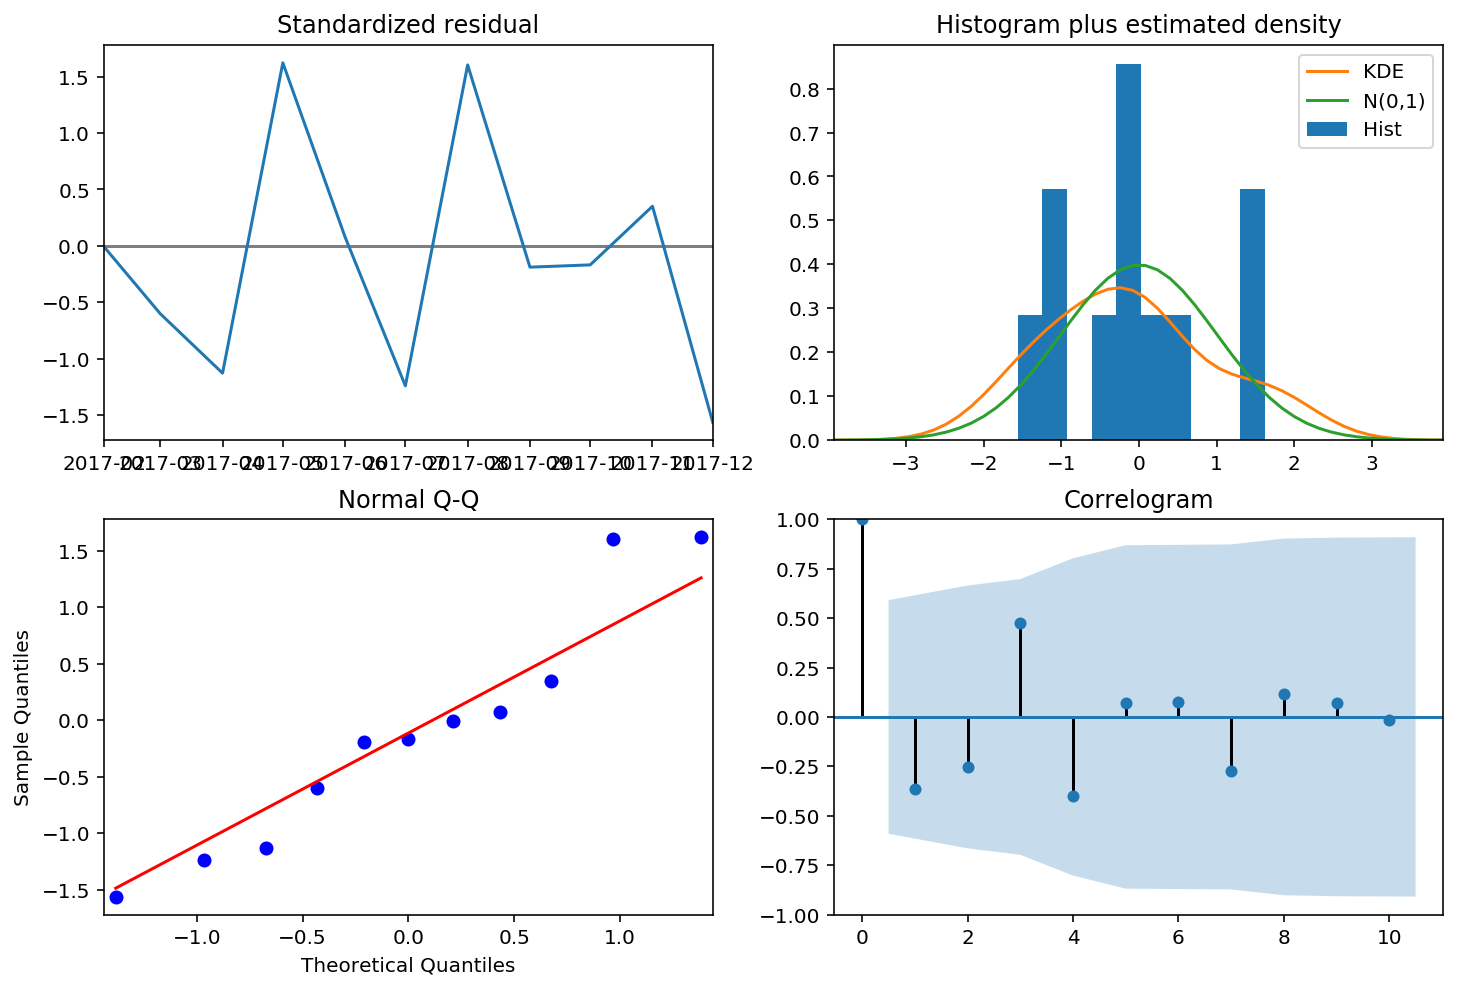

In [64]:
# 아래 결과를 보면 오차가 거의 정규분포를 따른다
results.plot_diagnostics(figsize=(12, 8))
plt.show()

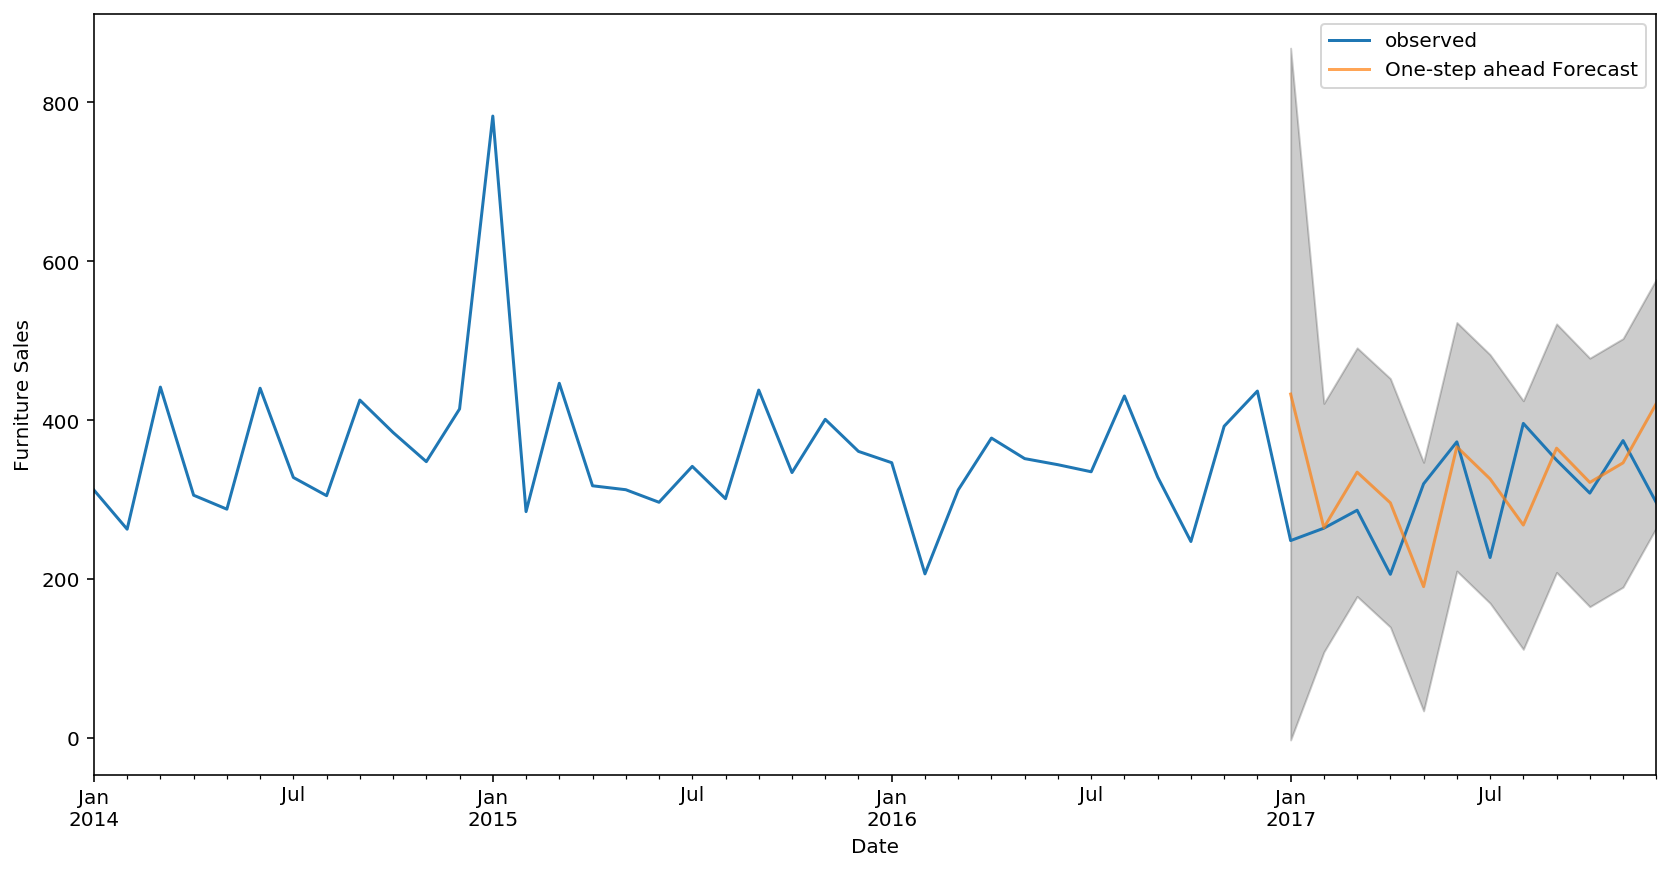

In [65]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [66]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE is {}'.format(round(mse, 2)))

MSE is 8667.87


In [67]:
print('RMSE is {}'.format(round(np.sqrt(mse), 2)))

RMSE is 93.1


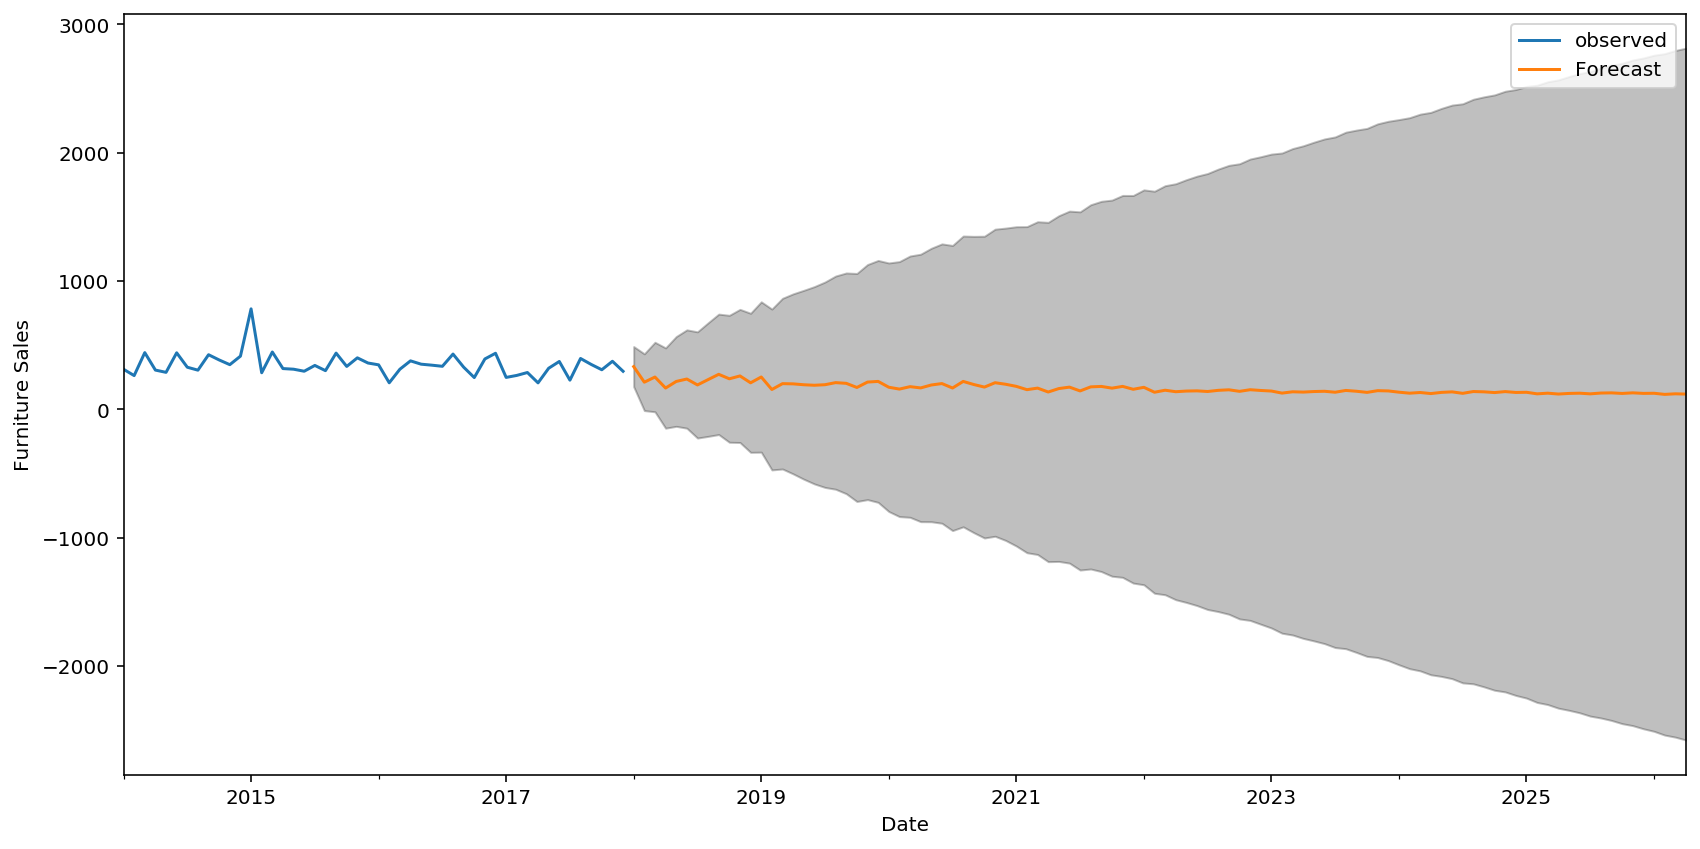

In [68]:
# steps 가 커질수록 confidence interval은 점차 증가한다.
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()


### 다른 항목과 비교 (가구 <-> 사무용품)

In [69]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [70]:
office[:3]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.0,6.8714
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368,2,0.2,2.5164
6,7,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.280,4,0.0,1.9656


In [71]:
furniture[:3]


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310


In [72]:
furniture = furniture[['Order Date', 'Sales']]
office = office[['Order Date', 'Sales']]
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

In [73]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

In [74]:
store = furniture.merge(office, how='inner', on='Order Date')
store[:3]

,Order Date,Sales_x,Sales_y
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318


In [75]:
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store[:3]

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318


In [76]:
store.shape

(48, 3)

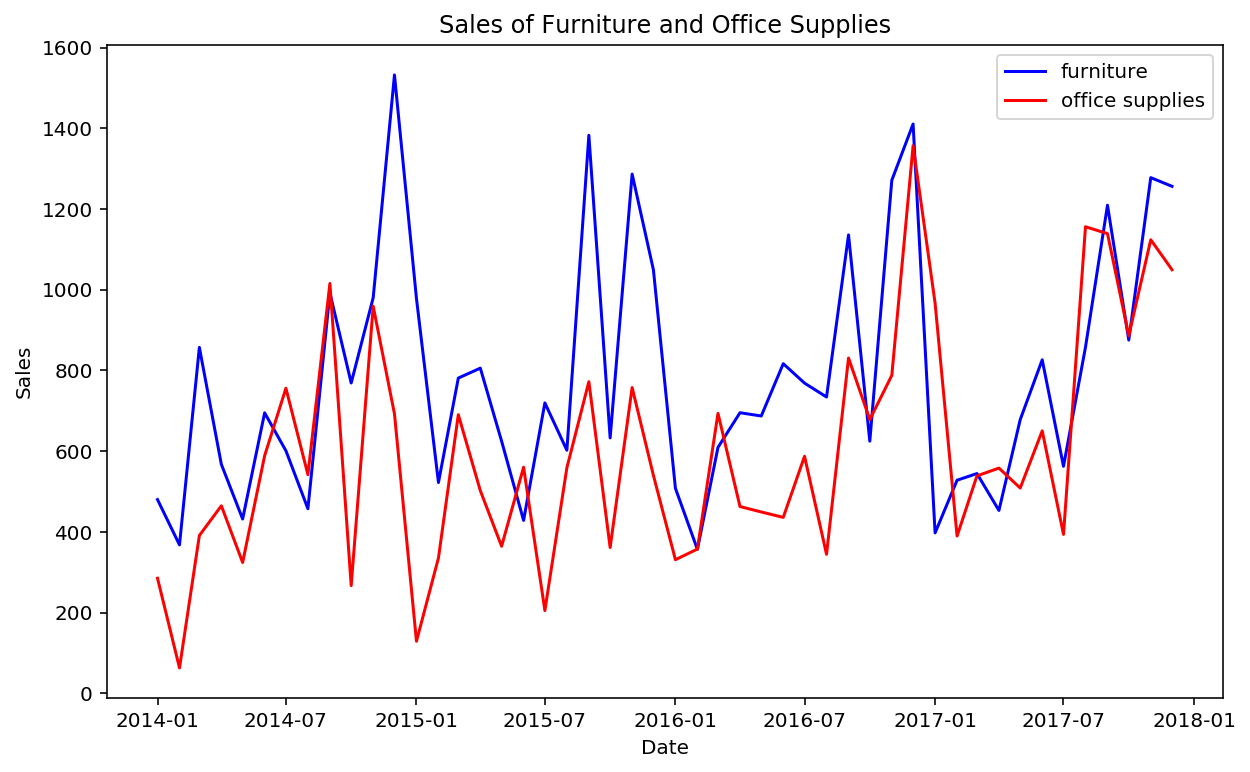

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); 
plt.title('Sales of Furniture and Office Supplies')
plt.legend();


- 유사한 계절적 특성을 갖는다.
- 사무용품 매출이 가구 매출을 앞지르는 시점을 찾아보겠다.

In [79]:
first_date = store.loc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']
print("사무용품 매출이 가구매출을 앞지르는 시점: {}.".format(first_date.date()))

사무용품 매출이 가구매출을 앞지르는 시점: 2014-07-01.


# Prophet
- 컬럼명을 ds, y로 지정해야 함

In [31]:
from fbprophet import Prophet
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

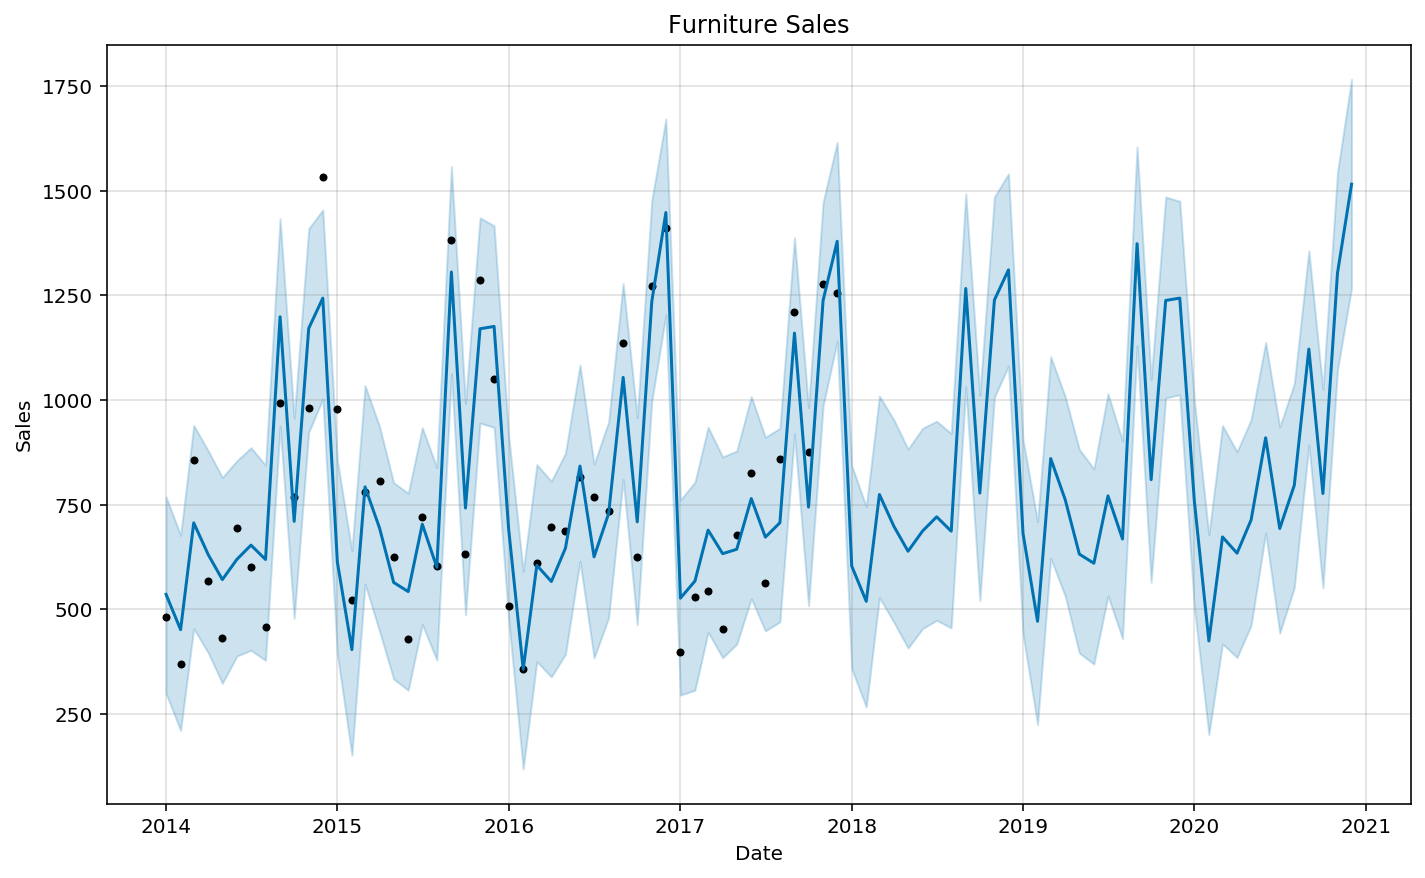

In [32]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1296x432 with 0 Axes>

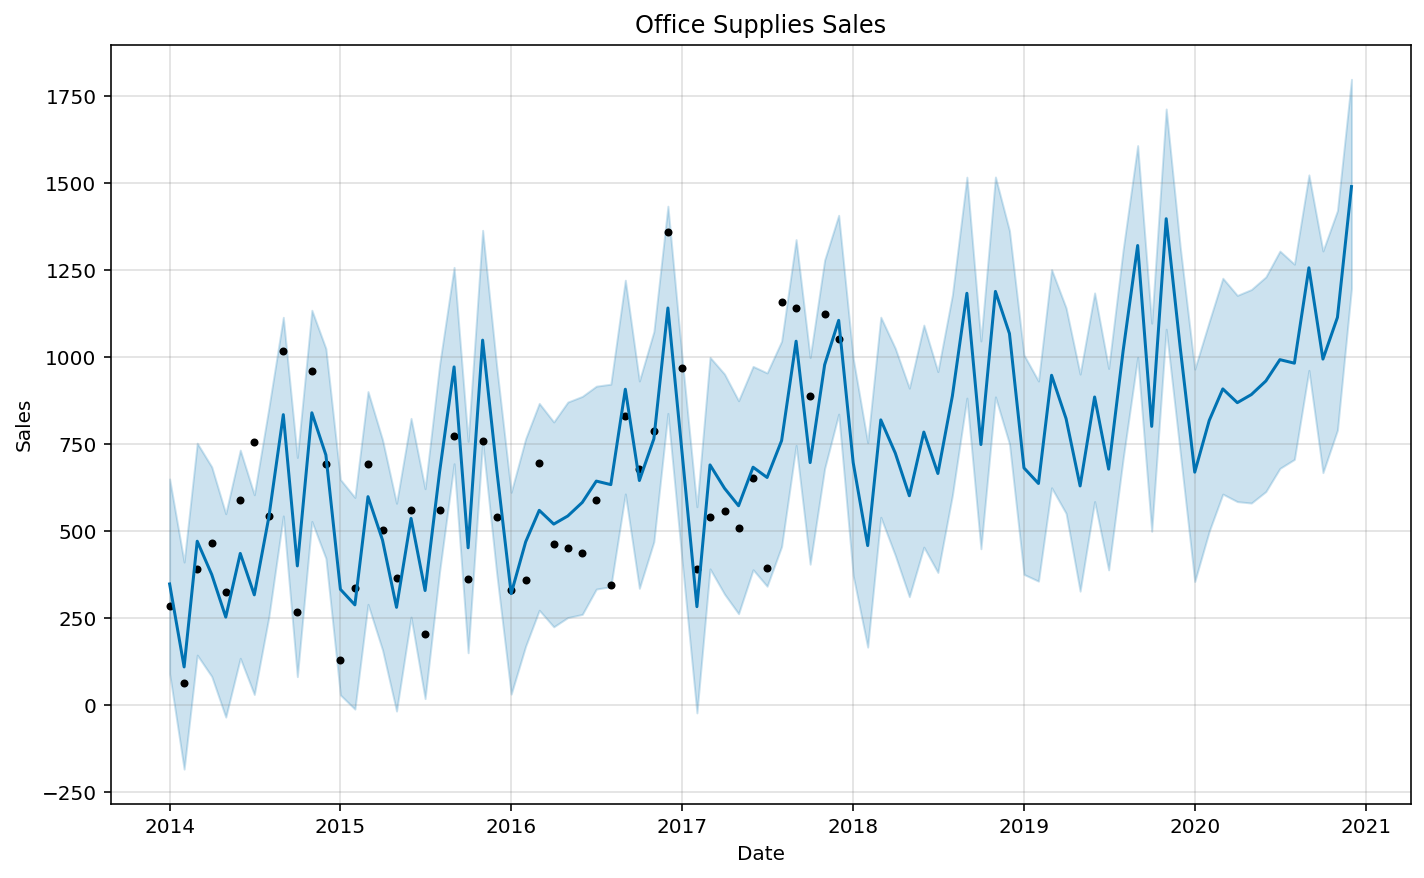

In [33]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

## 두개의 변수를 동시에 사용한 예측 모델 (참고)

In [34]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()
# 컬럼 이름 지정
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names
# 병합
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()


,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.057713,298.532712,768.580935,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,...,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,210.216401,676.595620,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,...,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,453.592631,939.171840,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,...,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,395.587735,878.267596,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,...,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,322.727972,814.892857,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,...,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


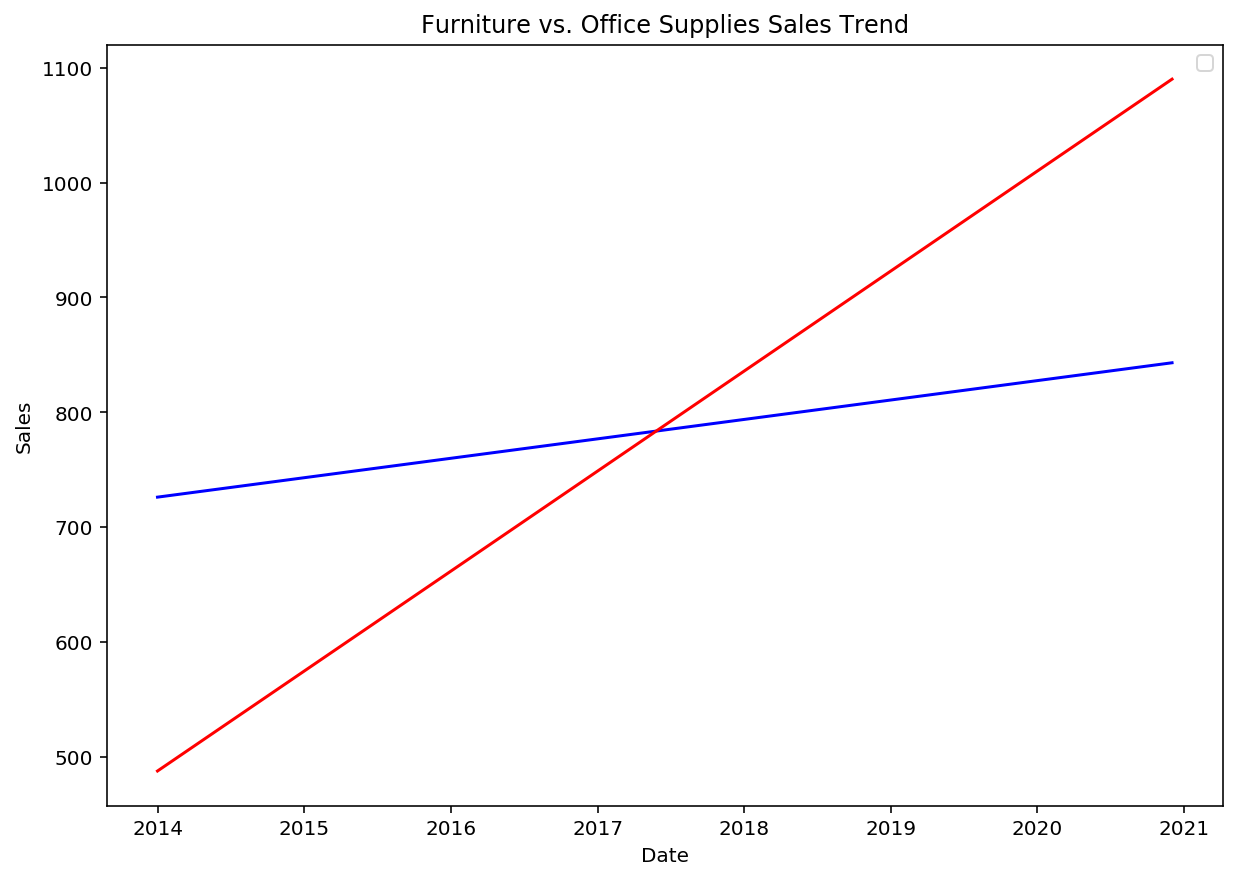

In [35]:
# 트렌드 시각화
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');


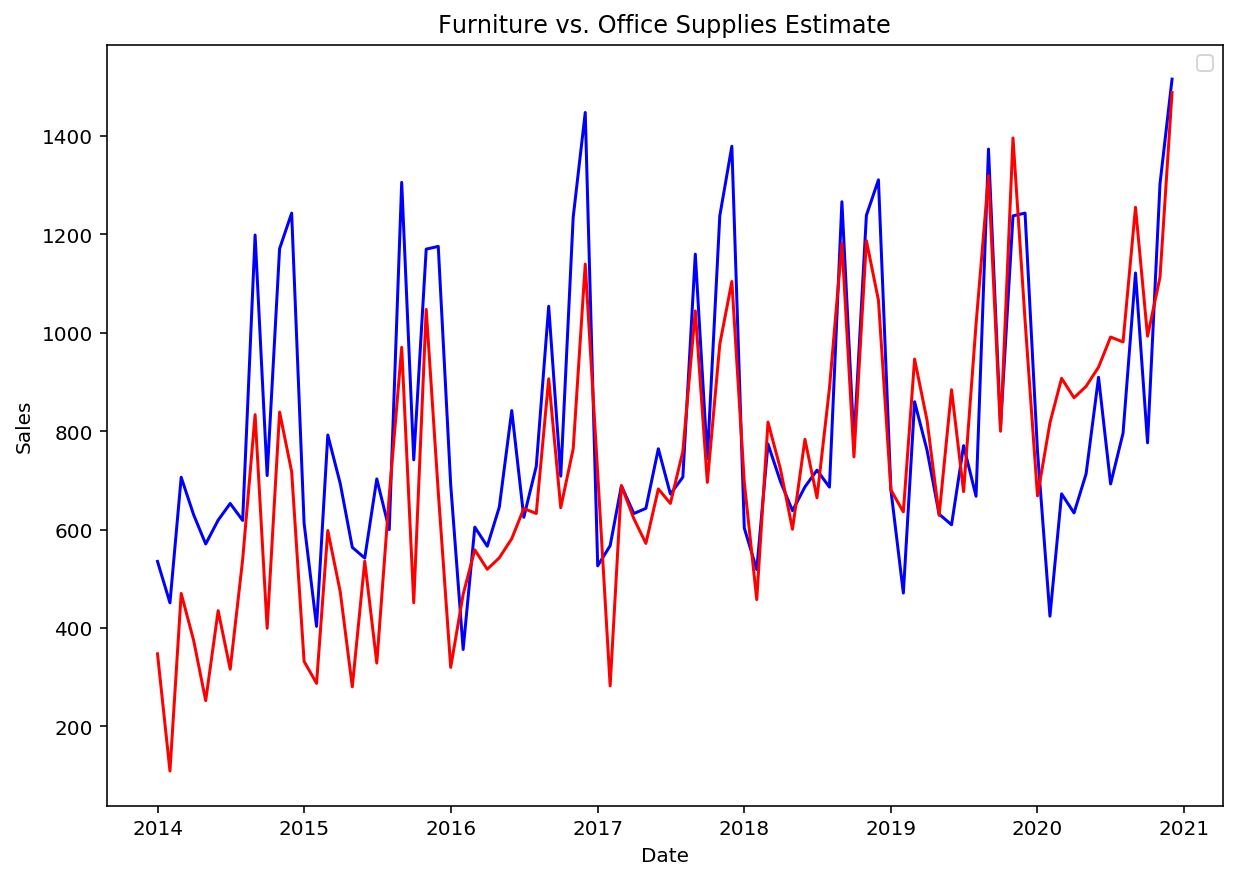

In [36]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');


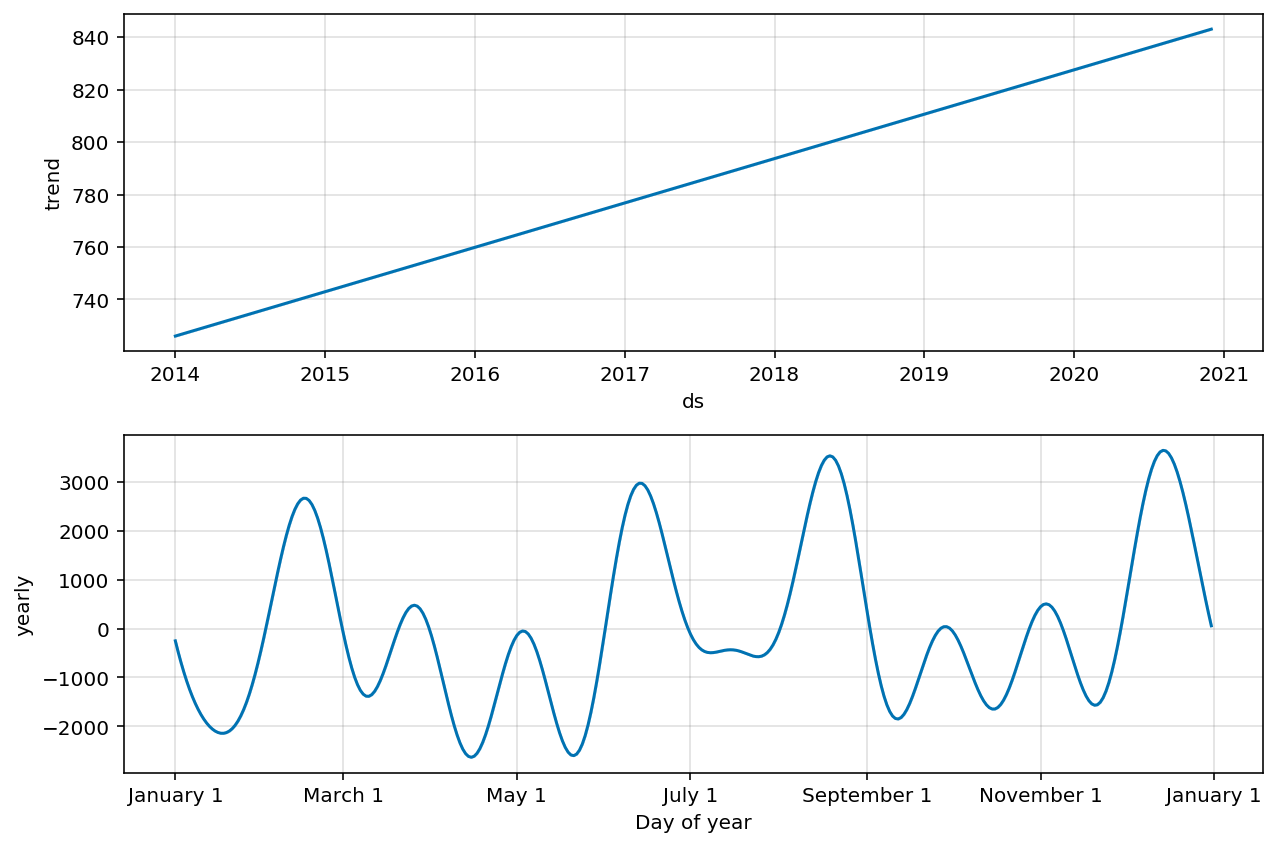

In [37]:
furniture_model.plot_components(furniture_forecast);


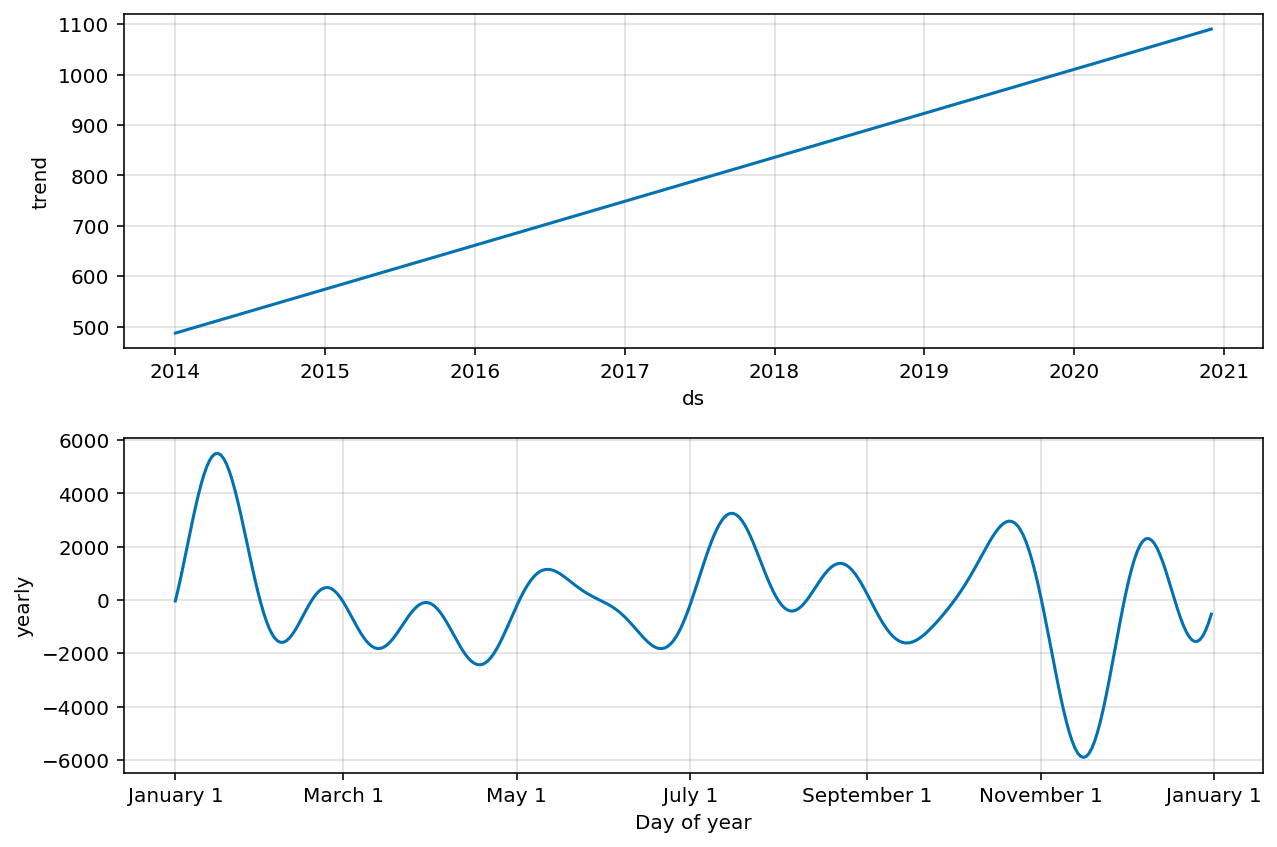

In [38]:
office_model.plot_components(office_forecast);